### <center><font> Tutorial #9 Computer- and robot-assisted surgery</font></center>
## <center><font> Registration 2</font></center>
<center>&copy; Micha Pfeiffer, National Center for Tumor Diseases (NCT) Dresden<br>
    <a href="https://www.nct-dresden.de/"><img src="https://www.nct-dresden.de/fileadmin/sites/nct-dresden.de/Resources/Public/Img/logo_en.jpg"></a> </center>

In this tutorial, we'll continue looking at registration. However, instead of fusing different point-clouds, we will fuse misaligned images. This can be used to fuse information of the same patient from different scans **(intra-subject)**, in order to build a more complete model for diagnosis, for example. Or it could be used to fuse images from different patients **(inter-subject)**, for example to build generalized models of an organ. To build such a registration system, it is important to differentiate between **multimodal** (different types of devices or settings used to obtain the images) or **monomodal** (same device and settings used), because it will drastically influence how we can compare images and measure alignmeent quality.

## <center><font color=navy>Preperation</font></center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

Let's start by loading some test images. They may have different shapes, so we'll pad them to have the same sizes. This is not necessary for the algorithms, it just makes some computationss easier later on.

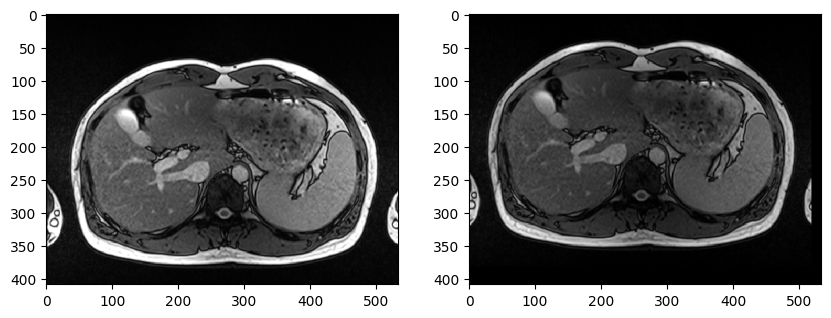

In [ ]:
source = cv2.imread("Exercises/Exercise12/source.png")
target = cv2.imread("Exercises/Exercise12/target.png")

# These images are MRI images. We're working with grayscale images, but the PNGs are saved as RGB images.
# To go back to grayscale, we can just extract only one of the R, G and B channels and throw away the others:
source = source[:,:,0]
target = target[:,:,0]

# PNG pixels are usually in the range from [0,255]. Let's scale to the range of [0,1]. Not necessary, just nicer to work with.
# NOTE: Real MRI and CT images will usually be saved in a differnt format because they have a finer granularity than just the 255
# possible values in our PNG. We'll ignore this for now and just work with the PNG images, because it doesn't have a large influence
# on what we'll do in the tutorial.
source = source/255
target = target/255

# Since the images may not be the same shape, we need to pad them first:
diff_x = max( source.shape[1] - target.shape[1], 0 )
diff_y = max( source.shape[0] - target.shape[0], 0 )
target = cv2.copyMakeBorder( target, top=0, bottom=diff_y, left=0, right=diff_x, borderType=cv2.BORDER_CONSTANT)
diff_x = max( target.shape[1] - source.shape[1], 0 )
diff_y = max( target.shape[0] - source.shape[0], 0 )
source = cv2.copyMakeBorder( source, top=0, bottom=diff_y, left=0, right=diff_x, borderType=cv2.BORDER_CONSTANT)

# Let's visualize the images next to each other.
# Note: We'll add the colormap "gray", because otherwise matplotlib automatically chooses a default color map:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(source, cmap="gray")
ax2.imshow(target, cmap="gray")

These two images are MRI images of the same patient, but they are misaligned. The goal for this tutorial is to automatically align them. Before we start, let's visualize them on top of each other to see the misalignment better:

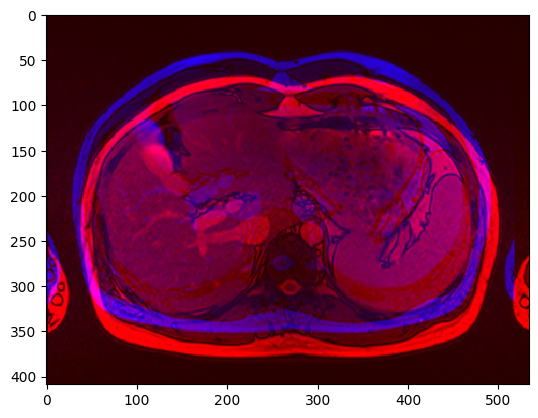

In [4]:
def overlay( img1, img2 ):
    """ Overlay two images.
    
    Note: this function assumes img1 and img2 have the same shape!
    
    Will show img1 in red and img2 in blue.
    """
    
    # Overlay the two images by scaling their pixel values and adding them together:
    r = img1[:,:,None]
    b = img2[:,:,None]
    g = np.zeros( b.shape )
    img = np.concatenate( (r, g, b), axis=2 )
    
    return img

# Test the overlay function with our source and target images:
plt.imshow( overlay( source, target ) )

We'll frequently need to apply a rotation and translation to an image, so let's define a helper function for this:

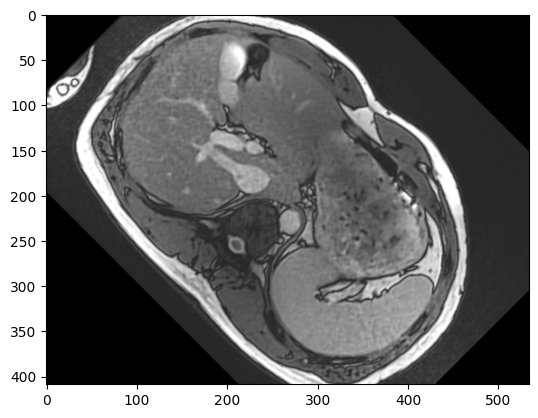

In [5]:
def apply_transform( img: np.ndarray, ang: float, x: float, y: float ):
    """ Rotate and shift an image
    
    Rotates the image and afterwards shifts it.
    
    Arguments:
        img: numpy array representing and open-cv style image
        ang: angle in degrees
        x: horizontal shift
        y: vertical shift
    """
    
    # Calculate a rotation matrix which rotates around the image center:
    image_center = tuple(np.array(img.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, ang, 1.0)
    
    # Add a translation to the matrix:
    transform = rot_mat
    transform[0,2] += x
    transform[1,2] += y
    
    # Apply the full transform to the image:
    img_transformed = cv2.warpAffine(img, transform, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return img_transformed

# Rotate by 45 degrees and shift a little in x and y:
plt.imshow( apply_transform( source, ang=-45, x=10, y=-20 ), cmap="gray" )

To get more familiar with the functions we've defined so far, we could try to guess the correct alignment:

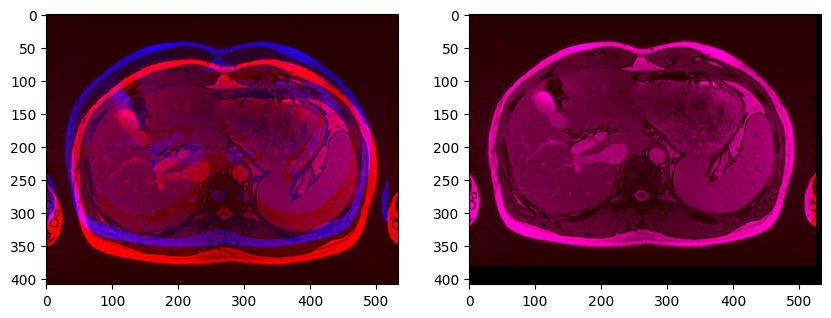

In [6]:
guessed_angle = 0
guessed_x_shift = -9
guessed_y_shift = -27

align_guess = apply_transform( source,
                ang = guessed_angle,
                x = guessed_x_shift,
                y = guessed_y_shift )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow( overlay( source, target ) )
ax2.imshow( overlay( align_guess, target ) )

## <center><font color=navy>Metrics</font></center>

To automate this process, we'll need a metric which will tell us how good our current alignment is. Since we're looking at **monomodal** images (both from an MRI, and both recorded using very similar settings), we can use the monomodal metrics defined on the following slide from the lecture:

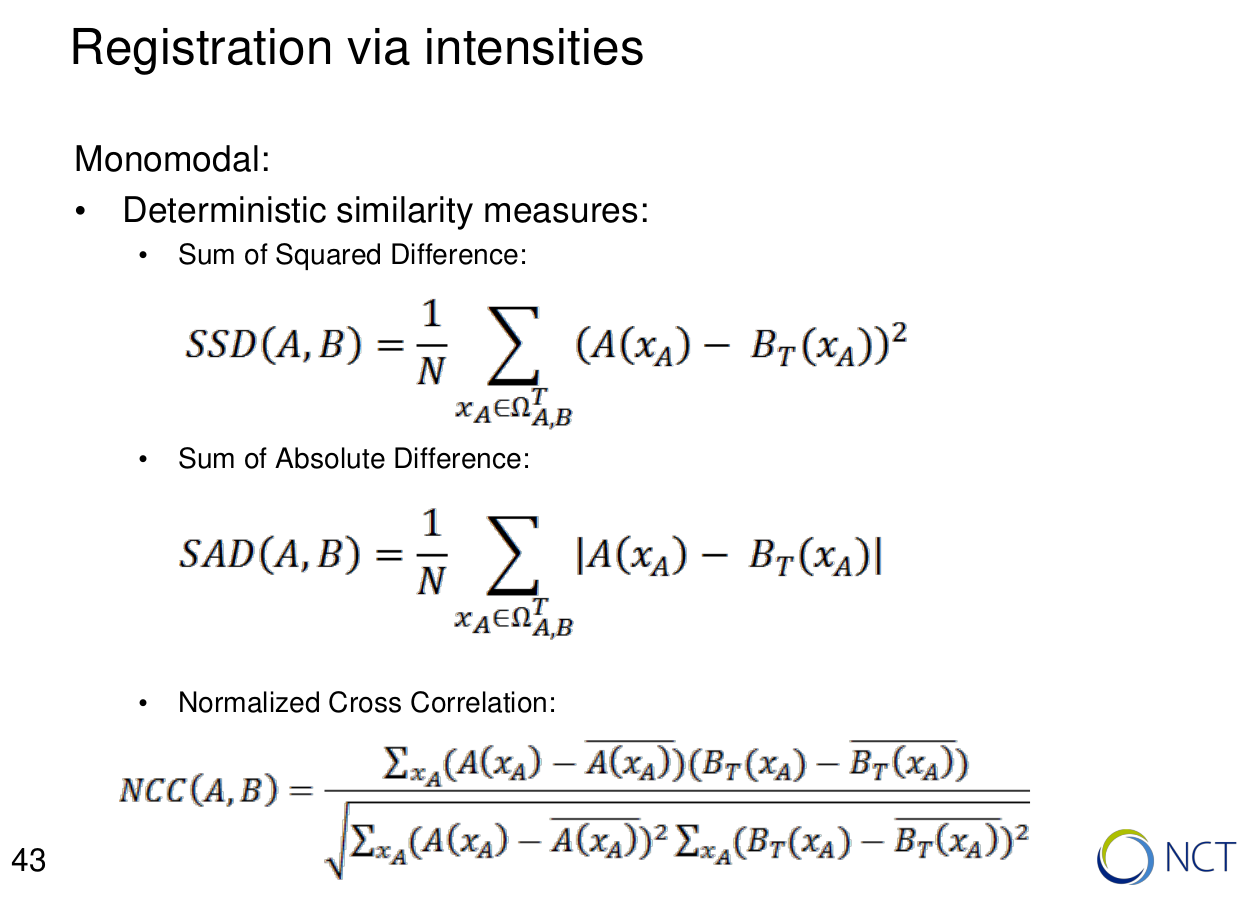

In [7]:
def SSD( A, B ):
    """ Sum of squared distances
    A, B: Images of same shape
    """
    return ((A-B)**2).mean()

def SAD( A, B ):
    """ Sum of absolute difference:
    """
    return (A - B).sum()

def NCC( A, B ):
    # Normalized cross-correlation
    a = A - A.mean()
    b = B - B.mean()
    
    numerator = ((A - A.mean()) * (B - B.mean())).sum()
    denominator = np.sqrt( ((A - A.mean())**2).sum() * ((B - B.mean())**2).sum() )
    
    assert denominator > 0, "NCC cannot be used on empty images"
    ncc = numerator/denominator
    
    # Note: NCC as defined on the slide is large when the images are aligned!
    # To get a metric that we can minimize (similar to SSD and SAD), we'll just negate it:
    return -ncc

Now we can compute a score for how well the original source and target are aligned, using any of our metrics. Note that the metrics aren't directly comparable, but for each of them a lower value means a better alignment.

In [8]:
print("SSD:", SSD( source, target ))
print("SAD", SAD( source, target ))
print("NCC", NCC( source, target ))

SSD: 0.0978052214556003
SAD 39986.57647058824
NCC -0.2347044516099938


## <center><font color=navy>Alignment Algorithm</font></center>

Now that we can measure the alignment, let's try to write a very simple alignment algorithm:

- We'll ignore the angle for now and only compute x- and y-shift.
- We'll use a brute-force approach, so we will shift the image around and track the metric for each shift. In the end, we can simply select the shift for which the metric was minimal.

Minimum at: (array([-9]), array([-27]))


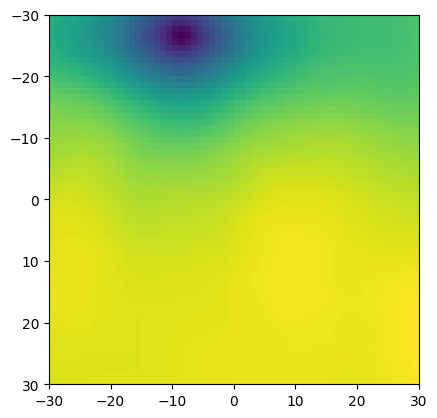

In [9]:

def brute_force_align( source, target, metric, start_shift: int = -30, end_shift: int = 30 ):
    """ Try various alignments, then select the best (according to the metric).
    
    Args:
        source, target: images as numpy ndarrays.
        metric: A function that takes an (aligned) source and target image
            and computes an alignment score for the two
        start_shift, end_shift: The range in which we want to test shifting.
            The algorithm will shift the image (horizontally and vertically)
            for every integer value between start_shift and end_shift, so
            it will compute (end_shift-start_shift)^2 trials.
    
    returns:
        x-shift, y-shift: The shifts in x and y
            which best align the image according to the metric.
    """
    
    start_shift = int(start_shift)
    end_shift = int(end_shift)
    assert start_shift < end_shift
    
    num_shifts = end_shift - start_shift
    
    # Set up a tensor (matrix) in which we can record the calculated
    # metric values:
    m = np.empty( (num_shifts, num_shifts) )
    
    for i in range( num_shifts ): # Iterate horizontally
        for j in range( num_shifts ): # iterate vertically
            # Calculate the current shift values:
            x_shift = start_shift + i
            y_shift = start_shift + j
            
            # Apply the current shift values to the source image, compare the result to the
            # target image using our metric, then store the result of the metric in m
            # at the current values of j and i, i.e. in m[j,i]
            
            # TODO
            m[j,i] = metric(apply_transform(source, 0, x_shift, y_shift), target)
            
    
    # Show the matrix holding the calculated metric values as an image:
    plt.imshow( m, extent=(start_shift, end_shift, end_shift, start_shift) )
    
    # Find the lowest value in the calculated metrics:
    best_metric = np.min(m)
    
    # Find _where_ this lowest value was, i.e. at what shift values:
    min_index = np.where(m == best_metric)
    
    # Since we stored values at i and j before, we'll now need to calculate the actual
    # shift values which were used to get this value, simply by offsetting by 'start_shift':
    min_index = (min_index[1] + start_shift, min_index[0] + start_shift)
    
    # The min_index is the shift which was used to obtain the minimum "error", i.e. where the
    # metric was minimal. This is the shift we're interested in!
    return min_index

# Test our brute-force method:
min_index = brute_force_align( source, target, metric=NCC )
print("Minimum at:", min_index)

The function takes a while to compute, but should then return the shifts at which the source and target images align best (assuming no rotation). Let's try it out by plotting the resulting alignment:

/var/folders/3f/vspzm0s56cv8d6_vgz15shf40000gn/T/ipykernel_29012/2732385885.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  transform[0,2] += x
/var/folders/3f/vspzm0s56cv8d6_vgz15shf40000gn/T/ipykernel_29012/2732385885.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  transform[1,2] += y


Text(0.5, 1.0, 'Source and target, aligned')

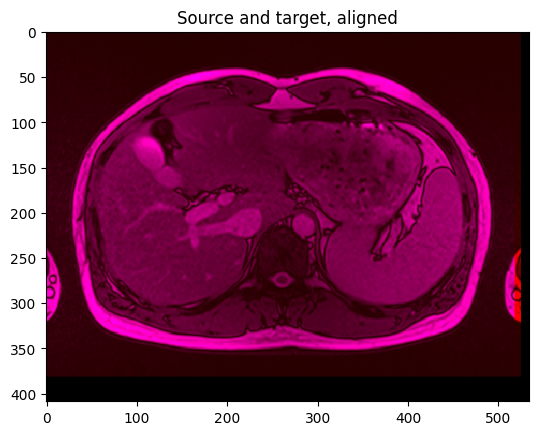

In [10]:
plt.imshow( overlay( apply_transform( source, 0, min_index[0], min_index[1] ), target ) )
plt.title("Source and target, aligned")

Obviously, this method will fail when source or target images are rotated. Let's try it out:

Minimum at: (array([-14]), array([16]))


/var/folders/3f/vspzm0s56cv8d6_vgz15shf40000gn/T/ipykernel_29012/2732385885.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  transform[0,2] += x
/var/folders/3f/vspzm0s56cv8d6_vgz15shf40000gn/T/ipykernel_29012/2732385885.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  transform[1,2] += y


Text(0.5, 1.0, 'Source and target after alignment')

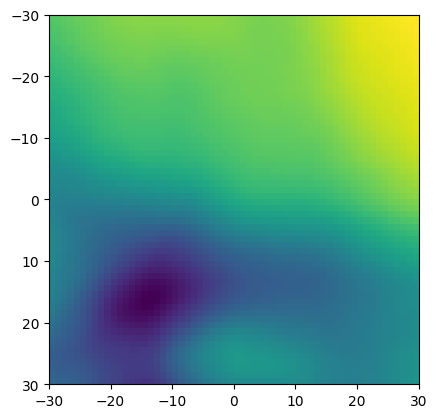

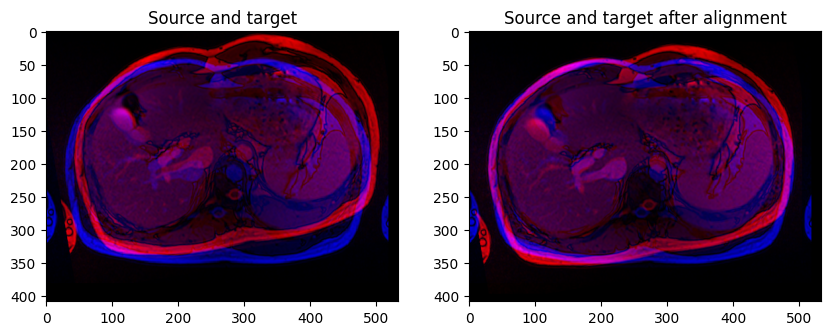

In [11]:
source_rot = cv2.imread("Exercise10/source_rot.png")
source_rot = source_rot[:,:,0]/255

# Since the images may not be the same shape, we need to pad them first:
diff_x = max( source_rot.shape[1] - target.shape[1], 0 )
diff_y = max( source_rot.shape[0] - target.shape[0], 0 )
target = cv2.copyMakeBorder( target, top=0, bottom=diff_y, left=0, right=diff_x, borderType=cv2.BORDER_CONSTANT)

diff_x = max( target.shape[1] - source_rot.shape[1], 0 )
diff_y = max( target.shape[0] - source_rot.shape[0], 0 )
source_rot = cv2.copyMakeBorder( source_rot, top=0, bottom=diff_y, left=0, right=diff_x, borderType=cv2.BORDER_CONSTANT)

# Attempt to align the images using our method:
min_index = brute_force_align( source_rot, target, metric=NCC )
print("Minimum at:", min_index)

# Show the source and target images:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow( overlay( source_rot, target ) )
ax1.set_title( "Source and target" )

# Show the alignmnet test result:
ax2.imshow( overlay( apply_transform( source_rot, 0, min_index[0], min_index[1] ), target ) )
ax2.set_title( "Source and target after alignment" )

An obvious and easy way to fix this would be to extend our brute-force search by also including an angle. However, this gets computationally infeasible very quickly - imagine testing just 20 different angles for **every** x- and y-shift - it would multiply our computation time by 20.

**Can you think about a better way to find the minimum?** Maybe have another look at the metric-maps which our brute-force method plots. Are all these trials really needed to find the minimum?

## <center><font color=navy>Gradient Descent</font></center>

We are essentially trying to solve an optimization problem by minimizing the image comparison metric. There are many approaches to solving this. Many of these approaches are based on knowing the gradient of the image metric (gradient of the loss) with respect to the current parameters (angle, x-shift and y-shift). This allows us to answer the question: At the current location, how should I change these parameters in order to improve (lower) the image comparison metric? Looking at the images of the metrics above, you'll notice that they look like landscapes with a clear minimum, and at every point, going "downhill", i.e. in the direction of the (negative) gradient will lead us closer to this minimum. So if we know what the gradient is at a given point, we'll know in what direction to go.

Finding this gradient could be done analytically, but then we'll have to figure out the gradient for every metric. Alternatively, we may be able to use an autograd-library like pytorch, which will automatically calculate gradients of (nested) functions. Here, we will take a simple, quite general approach: We'll estimate the gradient at the current point by probing other points around it.

In our case, the gradient is given by:

$∇M = (\frac{∂M}{∂α}, \frac{∂M}{∂x}, \frac{∂M}{∂y})^T$

We can approximate these partial derivatives via finite differences:

$\frac{∂M}{∂α} \rightarrow \frac{dM}{dα}$

$\frac{∂M}{∂x} \rightarrow \frac{dM}{dx}$

$\frac{∂M}{∂y} \rightarrow \frac{dM}{dy}$

So let's calculate this approximate gradient:

In [12]:
def gradient_approx( source, target, metric, d_ang=5, d_x=5, d_y=5 ):
    """ For the current source and target, approximate the gradient of m
    
    Do this by calculating the changes in the metric if we slightly change
    the ang, x or y.
    
    Returns: dM/dang, dM/dx, dM/dy
    """
    val_old = metric( source, target )
    
    val_new = metric( apply_transform( source, d_ang, 0, 0 ), target )
    d_val_d_ang = (val_new - val_old)/d_ang
    
    val_new = metric( apply_transform( source, 0, d_x, 0 ), target )
    d_val_d_x = (val_new - val_old)/d_ang
    
    val_new = metric( apply_transform( source, 0, 0, d_y ), target )
    d_val_d_y = (val_new - val_old)/d_ang
    
    return (d_val_d_ang, d_val_d_x, d_val_d_y)

# Let's test the gradient function:
gradient_approx( source_rot, target, SSD )

(np.float64(-0.0010170128070728396),
 np.float64(0.00013692418800799743),
 np.float64(-0.0008743100841688625))

With the gradient calculated, gradient descent is a relatively simply method to implement. The algorithm works as follows:

1. At the current step, calculate the gradient of the metric with respect to angle, x and y
2. Update angle, x and y by adding the gradient onto them (multiplied by a step-distance which controls how far we "step" into this direction
3. Go to step 1, unless we've reached convergence or a maximum number of steps.

-11.96822347189131 -18.349211781248282 22.262828468526347


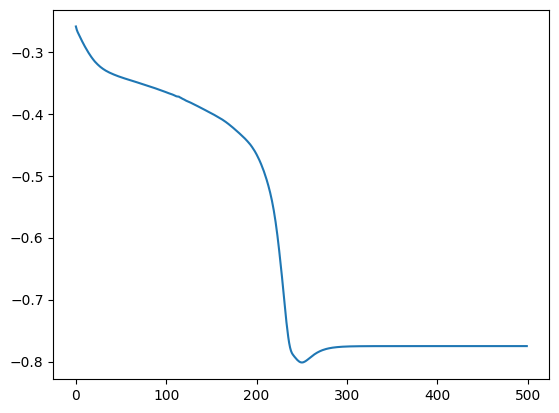

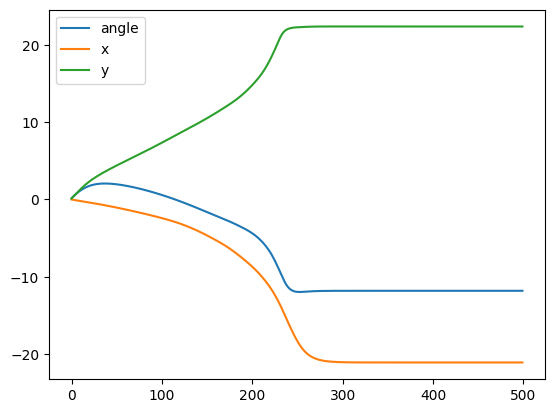

In [13]:
def align( source_orig, target, metric, num_steps=500, step_size=10, step_size_ang=10):
    x = 0
    y = 0
    ang = 0
    metric_progression = []
    angs = []
    xs = []
    ys = []
    for i in range(num_steps):
        source = apply_transform( source_orig, ang, x, y )
        
        # TODO: Calc approximate gradient at the current step and 
        d_val_d_ang, d_val_d_x, d_val_d_y = gradient_approx( source, target, metric=metric )
        
        # use it to update ang, x and y:
        ang = ang - (step_size_ang * d_val_d_ang)
        x = x - (step_size * d_val_d_x)
        y = y - (step_size * d_val_d_y)

        m = metric(source, target)
        metric_progression.append(m)
        angs.append(ang)
        xs.append(x)
        ys.append(y)
    
    fig = plt.figure()
    plt.plot( metric_progression, label="metric" )
    fig = plt.figure()
    plt.plot( angs, label="angle" )
    plt.plot( xs, label="x" )
    plt.plot( ys, label="y" )
    plt.legend()
    
    # Find the best value (in case it wasn't the last):
    min_m = min(metric_progression)
    min_index = metric_progression.index( min_m )
    
    ang = angs[min_index]
    x = xs[min_index]
    y = ys[min_index]
    
    return ang, x, y

ang, x, y = align( source_rot, target, metric=NCC )
print(ang, x, y)

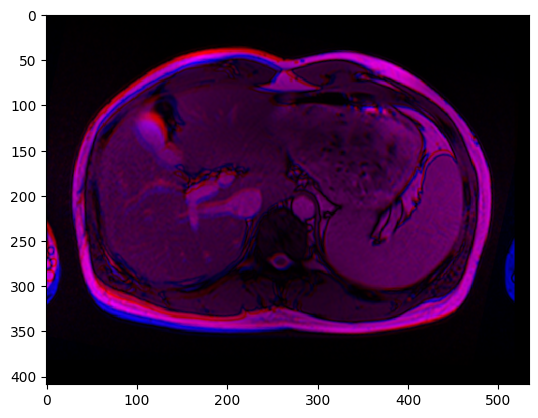

In [14]:
plt.imshow( overlay( apply_transform( source_rot, ang, x, y ), target ) )

How would you improve the alignment further?

The method does not work as well with SAD or SSD. Why?

- Can you find a way to make it work also with SAD or SSD?

The methods described here will usually not work well to fuse multimodal images, for example MRI and CT, or CT and Ultrasound.

- Why?
- What could be changed in order to make these methods also work in multimodal settings?

The method also only computes rigid alginment.

- Can you think of a different method which could also deal with deformation?